# DIGIT RECOGNIZER

## 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## 2. Data preprocessing

In [4]:
base_path = "./data"  ## personal use
# base_path = "/kaggle/input/digit-recognizer"  ## for kaggle


In [5]:
test_path = f"{base_path}/test.csv"
train_path = f"{base_path}/train.csv"

In [6]:
# Loading dataset
test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

In [7]:
X_train = train.iloc[:,1:].values.astype('float32') 
Y_train = train.iloc[:,0].values.astype('int32')
X_test = test.values.astype('float32')

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize
X_train /= 255
X_test /= 255

print("Training shape", X_train.shape)
print("Testing shape", X_test.shape)

Training shape (42000, 28, 28, 1)
Testing shape (28000, 28, 28, 1)


In [8]:
# Label encoding
Y_train = to_categorical(Y_train, 10)

label:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


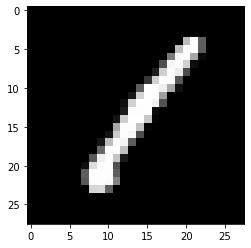

In [9]:
plt.imshow(X_train[0], cmap='gray')
print("label: ", Y_train[0])

In [10]:
# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, random_state=42)

## 3. Creating model

In [11]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) 
model.add(BatchNormalization(axis=-1))               
model.add(Activation('relu'))

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        
model.add(BatchNormalization(axis=-1))               
model.add(Activation('relu'))                        
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer 3
model.add(Conv2D(64, (3, 3)))                        
model.add(BatchNormalization(axis=-1))               
model.add(Activation('relu'))

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        
model.add(BatchNormalization(axis=-1))               
model.add(Activation('relu'))                              
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())                                

# Fully Connected Layer 5
model.add(Dense(512))                                
model.add(BatchNormalization())                     
model.add(Activation('relu'))                       

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                            
model.add(Dense(10))
model.add(Activation('softmax'))   

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

## 4. Training model

In [13]:
# Batch size, Epochs
batch_size = 64
epochs = 100

In [14]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
## Defining callbacks

# Reduce LearningRate gradually to converge
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    factor = 0.5,
    min_lr = 0.00001
)

# Stop if Loss was not improved
early_stopping = EarlyStopping(
    monitor = "val_loss",
    restore_best_weights = True,
    patience = 1
)

# Save best weights if Loss didn't improve
model_checkpoint = ModelCheckpoint(
    './tmp/checkpoint',
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
)

In [16]:
# Data augumentation
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=0.3,
                         height_shift_range=0.1, zoom_range=0.1)
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)

In [17]:
%%time
# Training
history = model.fit(train_generator, epochs = epochs, batch_size=batch_size, validation_data = (X_val,Y_val),
                   callbacks=[learning_rate_reduction, model_checkpoint, early_stopping])

Epoch 1/100
525/525 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9411

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


525/525 [==============================] - 59s 110ms/step - loss: 0.1886 - accuracy: 0.9411 - val_loss: 0.1291 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9765

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


525/525 [==============================] - 59s 112ms/step - loss: 0.0750 - accuracy: 0.9765 - val_loss: 0.0488 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9820

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


525/525 [==============================] - 59s 113ms/step - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.0458 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 59s 112ms/step - loss: 0.0538 - accuracy: 0.9837 - val_loss: 0.0478 - val_accuracy: 0.9839 - lr: 0.0010
Wall time: 3min 55s


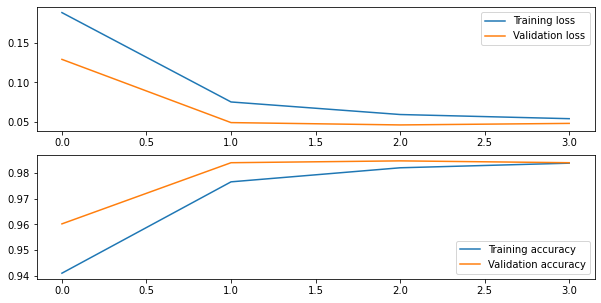

In [18]:
fig, ax = plt.subplots(2,1, figsize = (10, 5))
for i, metric in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[metric], label = f"Training {metric}")
    ax[i].plot(history.history[f'val_{metric}'], label = f"Validation {metric}", axes = ax[i])
    ax[i].legend()

## 5. Prediction

In [19]:
%%time
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_pred_classes[:5]

875/875 [==============================] - 9s 11ms/step
Wall time: 9.82 s


array([2, 0, 9, 0, 3], dtype=int64)

In [20]:
submission = pd.DataFrame({"ImageID": list(range(1,len(Y_pred_classes) + 1)),
                          "Label": Y_pred_classes})
submission.to_csv("submission.csv", index=False, header=True)

## 6. Save model

In [21]:
model.save('digit_recog.h5')